# **House Price Prediction**

In [44]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams["figure.figsize"] = (20, 10)
%matplotlib inline

## **Helper Functions**

In [45]:
def is_float(x):
  try:
    float(x)
  except:
    return False
  return True

In [46]:
def range_average(x):
  tokens = x.split("-")
  if len(tokens) == 2:
    return ((float(tokens[0]) + float(tokens[1]))/2)
  try:
    return float(x)
  except:
    return None

In [47]:
def clean_price_per_sqft(dataframe):
  '''A function which only considers values that are -> <= (mean - standard) and >= (mean + standard).'''
  Output = pd.DataFrame()
  
  for key, subdataframe in dataframe.groupby("location"):
    mean = np.mean(subdataframe.price_per_sqft)
    std = np.std(subdataframe.price_per_sqft)
    new_database = subdataframe[(subdataframe.price_per_sqft > (mean - std)) & (subdataframe.price_per_sqft <= (mean + std))]
    Output = pd.concat([Output, new_database], ignore_index = True)
  return Output

In [48]:
def plot_location_scatter(dataframe, location):
  ''' Given location, plot the price and total_sqft of 2,3 BHK'''
  BHK2 = dataframe[(dataframe.location == location) & (dataframe.BHK == 2)]
  BHK3 = dataframe[(dataframe.location == location) & (dataframe.BHK == 3)]
  
  matplotlib.rcParams["figure.figsize"] = (15, 10)
  plt.scatter(BHK2.total_sqft, BHK2.price, color = "blue", label = "2 BHK", s = 50)
  plt.scatter(BHK3.total_sqft, BHK3.price, marker = "+", color = "green", label = "3 BHK", s = 50)
  plt.xlabel("Total Square Feet Area")
  plt.ylabel("Price (Lakh Indian Rupees)")
  plt.title(location)
  plt.legend()

In [49]:
def remove_BHK_outliers(dataframe):
  '''Using mean of (n-1), remove the ones above it from n'''
  exclude = np.array([])
  for location, location_dataframe, in dataframe.groupby("location"):
    BHK_statistics = {} # Stores the described statistics for each BHK
    for BHK, BHK_dataframe in location_dataframe.groupby("BHK"):
      BHK_statistics[BHK] = {
          "mean" : np.mean(BHK_dataframe.price_per_sqft),
          "std" : np.std(BHK_dataframe.price_per_sqft),
          "count" : BHK_dataframe.shape[0]
                            }

    for BHK, BHK_dataframe in location_dataframe.groupby("BHK"):
      # Part I don't understand lol
      statistics = BHK_statistics.get(BHK - 1)
      if statistics and statistics["count"] > 5:
        exclude = np.append(exclude, BHK_dataframe[BHK_dataframe.price_per_sqft < (statistics["mean"])].index.values)
  return dataframe.drop(exclude, axis = "index")


# **Data Preparation**

## **Data Loading**

In [50]:
original_data = pd.read_csv("/content/Bengaluru_House_Data.csv")
original_data.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [51]:
# original_data.shape -> (13320, 9)

# original_data.columns -> Index(['area_type', 'availability', 'location', 'size', 'society', 'total_sqft', 'bath', 'balcony', 'price'], dtype='object')

Testing "area_type" and dropping it if not useful, along with others

In [52]:
# original_data["area_type"].unique() -> array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area', 'Carpet  Area'], dtype=object)

# original_data["area_type"].value_counts() -> 
# Super built-up  Area    8790
# Built-up  Area          2418
# Plot  Area              2025
# Carpet  Area              87
# Name: area_type, dtype: int64

Dropping Useless Features

In [53]:
data = original_data.drop(["area_type", "society", "balcony", "availability"], axis = "columns")
# data.shape -> (13320, 5)

## **Data Cleaning**

In [54]:
# data.isnull().sum() ->
# location       1
# size          16
# total_sqft     0
# bath          73
# price          0
# dtype: int64

data = data.dropna() # Dropping the fields with NA value 

# data.isnull().sum() ->
# location      0
# size          0
# total_sqft    0
# bath          0
# price         0
# dtype: int64

# data.shape -> (13246, 5)

## **Feature Engineering**

In [55]:
# data.head()

In [56]:
data["BHK"] = data["size"].apply(lambda x: int(x.split(' ')[0]))

data = data.drop(["size"], axis = "columns") # Size -> BHK, and dropped Size

# data.BHK.unique() -> array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12, 13, 18])

In [57]:
data.head()

,location,total_sqft,bath,price,BHK
0,Electronic City Phase II,1056,2.0,39.07,2
1,Chikka Tirupathi,2600,5.0,120.00,4
2,Uttarahalli,1440,2.0,62.00,3
3,Lingadheeranahalli,1521,3.0,95.00,3
4,Kothanur,1200,2.0,51.00,2


### Working with total_sqft feature

In [58]:
data[~data["total_sqft"].apply(is_float)].head(10) # Checking for non-float values in the total_sqft column

,location,total_sqft,bath,price,BHK
30,Yelahanka,2100 - 2850,4.0,186.000,4
122,Hebbal,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,1042 - 1105,2.0,54.005,2
165,Sarjapur,1145 - 1340,2.0,43.490,2
188,KR Puram,1015 - 1540,2.0,56.800,2
410,Kengeri,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,1195 - 1440,2.0,63.770,2
648,Arekere,4125Perch,9.0,265.000,9
661,Yelahanka,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,3090 - 5002,4.0,445.000,4


For the ranges, we will take average, as for others non float values, they are dropped.

In [59]:
data.total_sqft = data.total_sqft.apply(range_average)
# data.head()

In [60]:
# data.shape -> (13246, 5) # Upon testing it was found, that there were no null fields in the total_sqft column

### Price-per-square-feet

In [61]:
data["price_per_sqft"] = (data["price"] / data["total_sqft"]) * 100000
# data.head()

In [62]:
# data.price_per_sqft.describe() ->
# count    1.320000e+04
# mean     7.920759e+03
# std      1.067272e+05
# min      2.678298e+02
# 25%      4.267701e+03
# 50%      5.438331e+03
# 75%      7.317073e+03
# max      1.200000e+07
# Name: price_per_sqft, dtype: float64

### Categorical Variable (Locations)

In [63]:
data.location = data.location.apply(lambda x: x.strip())
location_counts = data["location"].value_counts (ascending = False)
# ->
# Whitefield                        535
# Sarjapur  Road                    392
# Electronic City                   304
# Kanakpura Road                    266
# Thanisandra                       236
#                                  ... 
# Vasantapura main road               1
# Bapuji Layout                       1
# 1st Stage Radha Krishna Layout      1
# BEML Layout 5th stage               1
# Abshot Layout                       1
# Name: location, Length: 1293, dtype: int64

# location_counts.values.sum() -> 13246 # Total number of values in locations (Duplicate locations counted)
# len(location_counts[location_counts > 10]) -> 241 # Number of locations with count > 10
# len(location_counts) -> 1293 # Number of locations
# len(location_counts[location_counts <= 10]) -> 1052 # Number of locations with count <= 10


## **Dimensionality Reduction**

Location with less than 10 count will be shifted to "Other".

In [64]:
# location_counts

In [65]:
location_count_low = location_counts[location_counts <= 10]
# location_count_low # Contains the names of the locations that have count <= 10

data.location = data.location.apply(lambda x: "Other" if x in location_count_low else x)
# len(data.location.unique()) -> 242 # Locations with > 10 count are 242

In [66]:
data.head(10)

,location,total_sqft,bath,price,BHK,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,1310.0,3.0,63.25,3,4828.244275
9,Other,1020.0,6.0,370.00,6,36274.509804


**One hot encoding will be performed on these locations later.**

## **Outlier Removals**

### Logic

According to Market Experts, 300 ft per BHK is the nominal deal.

In [67]:
# data[(data.total_sqft/data.BHK) < 300].head() # Locations with abnormal sq_ft per BHK

In [68]:
# data.shape -> (13246, 6) # Before removing abnormal locations
data = data[~((data.total_sqft/ data.BHK) < 300)]
# data.shape -> (12502, 6) # After removing abnormal locations

### Standard Deviation and Mean

In [69]:
data.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

It is visible that there is a huge variation between the min and the max, thus we should remove the outliers, this is done using a function which only considers values that are
-> <= (mean - standard) and >= (mean + standard).

In [70]:
data_testing = clean_price_per_sqft(data) # Testing if the output is correct, without messing the original up
# data_testing.shape -> (10241, 6)
data = data_testing.copy()
# data.shape -> (10241, 6)

In [71]:
# data.price_per_sqft.describe() ->
# count    10241.000000
# mean      5657.702572
# std       2266.476980
# min       1250.000000
# 25%       4244.762955
# 50%       5172.413793
# 75%       6426.099852
# max      24509.803922
# Name: price_per_sqft, dtype: float64

There are certain events where the price of 3 BHK is lesser than 2 BHK, while keeping everything else the same.

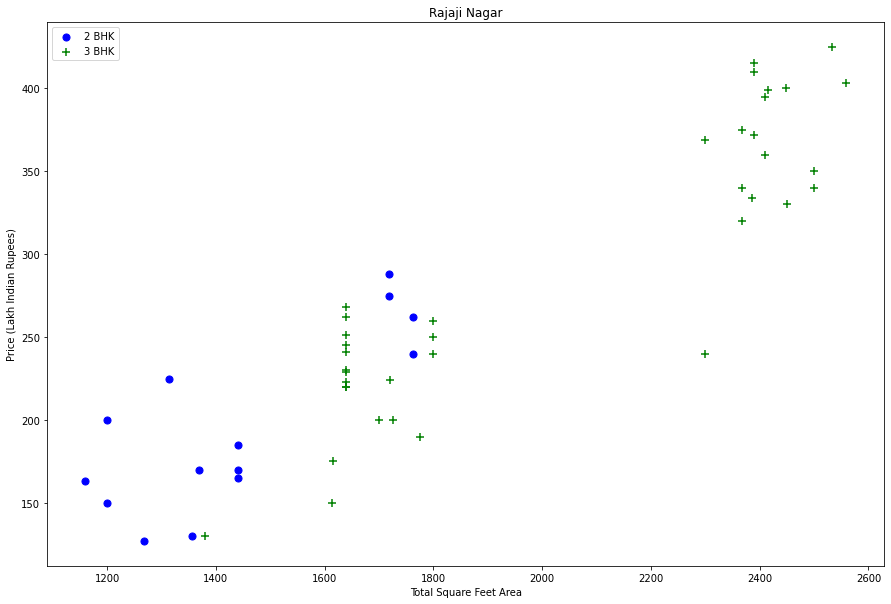

In [72]:
plot_location_scatter(data, "Rajaji Nagar")

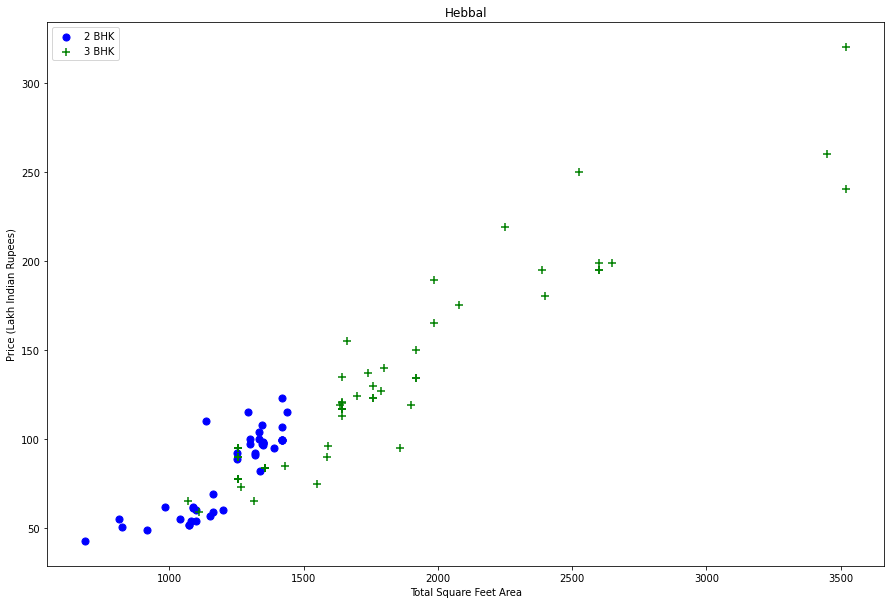

In [73]:
plot_location_scatter(data, "Hebbal")

Now we will remove outliers where the price of n BHK is less than (n-1) BHK, given that all the other features are the same.

In [74]:
data_testing = remove_BHK_outliers(data) # All the fields where price of 3 is greater than 2 are removed
# data_testing.shape -> (7329, 6)
data = data_testing.copy()
# data.shape -> (7329, 6)

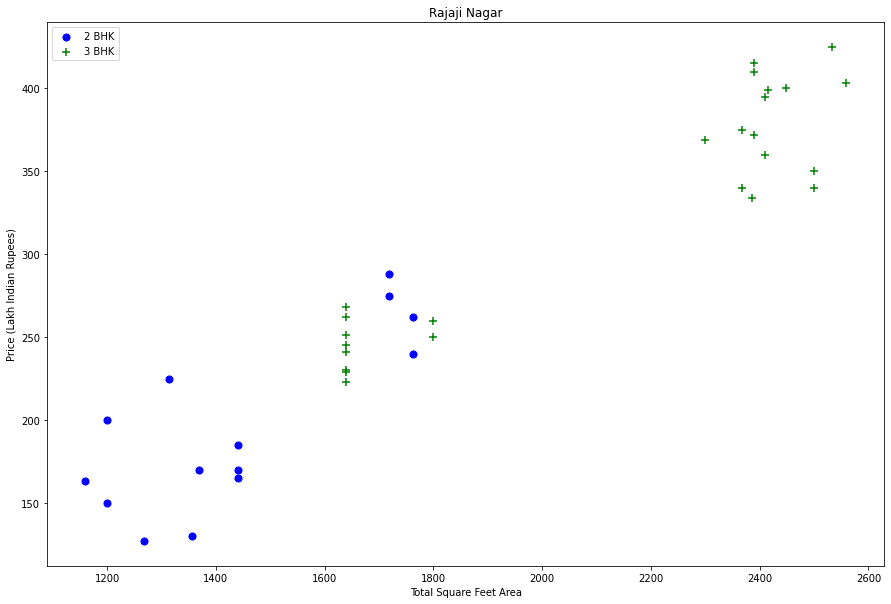

In [75]:
plot_location_scatter(data, "Rajaji Nagar")

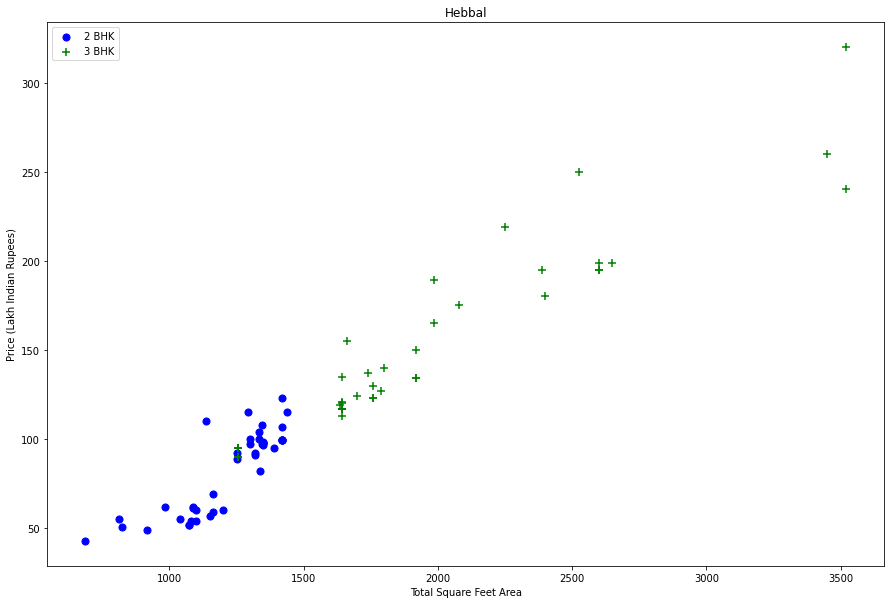

In [76]:
plot_location_scatter(data, "Hebbal")

As can be seen from the new graphs, there are no values where the price of the 3 BHK is lower than 2 BHK.

### Bathrooms

In [77]:
# data.bath.unique()
# plt.hist(data.bath, rwidth = 0.4)
# plt.xlabel("Number of bathrooms")
# plt.ylabel("Count")
# data[data.bath > 10]
# data[data.bath > data.BHK + 2] # Abnomalities where the number of bathroom is 2 more than BHK 

In [78]:
data = data[data.bath < data.BHK + 2] # Remove instances where Bathro
# data.shape -> (7251, 6)

Now that we have removed the outliers based on price_per_sqft, we can remove it from the columns.

In [79]:
data = data.drop(["price_per_sqft"], axis = "columns")
# data.head()

## **One Hot Encoding for Categorical Variable (Location)**

In [80]:
dummy = pd.get_dummies(data.location)
# data.head()

get_dummies() creates a dummy column for every unique element under location.
Now, we need to concatenate the original database with the dummies.

Now that the dummies have been set up, we will remove the only column containing texts, "locations".

In [81]:
data = pd.concat([data, dummy.drop("Other", axis = "columns")], axis = "columns")
data = data.drop("location", axis = "columns")
# data.shape -> (7251, 245)
# data.head()

,location,total_sqft,bath,price,BHK,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# **Model Selection and Building**

### **Data Split**

In [84]:
data.head()

,total_sqft,bath,price,BHK,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now, for the model building part, we need to split the data into features (X) and labels (Y).

In [85]:
X = data.drop(["price"], axis = "columns")
# X.head()

,total_sqft,bath,BHK,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
y = data.price
# y.head(3)

0    428.0
1    194.0
2    235.0
Name: price, dtype: float64

Now we further split the data into training and testing, keeping the test_set as 20% of the total dataset.

In [87]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

Now that we have all the data prepared we can start using prebuilt models and see which one works better than the others.

Starting with LinearRegression. 

### **Linear Regression**

In [88]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

0.8691914452174594

The Accuracy came out to be 86%, which is pretty good but can be better, let's keep trying.

Let's use **K-fold cross validation** to split the training dataset into multiple folds, train it on them and then take the average score to see how the model performs.

In [95]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cross_val = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
cross_val_score(LinearRegression(), X, y, cv = cross_val)

array([0.85430675, 0.84187647, 0.84728412, 0.85171729, 0.87168018])

**n_splits**: number of splits of the training set.

**test_size**: testing percentage of the total dataset. 

**random_state**: Used in order to prevent randomization on each run (Avoids overfitting).

### **GridSearchCV**

We can either manuallly check for all the models, or we can deploy GridSearchCV to check for all.

Using **GridSearchCV** to find the best model.
We will check for two, Lasso and DecisionTreeRegressor. 

In [99]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def using_GridSearchCV(X, y):
  models = {
      "linear_regression" : {
          "model" : LinearRegression(),
          "params" : {
              "normalize" : [True, False]
          }
      },
      "lasso" : {
          "model" : Lasso(),
          "params" : {
              "alpha" : [1, 2],
              "selection" : ["random", "cyclic"]
          }
      },
      "decision_tree" : {
          "model" : DecisionTreeRegressor(),
          "params" : {
              "criterion" : ["mse", "friedman_mse"],
              "splitter" : ["best", "random"]
          }
      }
  }

  scores = []
  cross_val = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
  for model_name, config in models.items():
    # "For every model, fit the dataset and calculate the score"
    GridSearch = GridSearchCV(config["model"], config["params"], cv = cross_val, return_train_score = False)
    GridSearch.fit(X, y)

    scores.append({
        "model" : model_name,
        "score" : GridSearch.best_score_,
        "parameters" : GridSearch.best_params_,
    })

  return pd.DataFrame(scores, columns = ["model", "score", "parameters"]) 

In [100]:
using_GridSearchCV(X, y)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pi

,model,score,parameters
0,linear_regression,0.853373,{'normalize': False}
1,lasso,0.727543,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.684999,"{'criterion': 'mse', 'splitter': 'best'}"


# **Model Testing and Export**

In [102]:
data.head(3)

,total_sqft,bath,price,BHK,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Testing

In order to pass the testing data into the model, it has to be passed in a dataframe form, so we will first convert it into a dataframe and then pass it.

In [106]:
def predict(location, sqft, bath, BHK):
  loc_index = np.where(X.columns == location)[0][0] # Important

  x = np.zeros(len(X.columns)) # Create an empty array

  # Set the array values
  x[0] = sqft
  x[1] = bath
  x[2] = BHK

  if loc_index >= 0:
    x[loc_index] =  1

  return lr_clf.predict([x])[0] # Return the price predicted

In [113]:
# predict("1st Phase JP Nagar", 1000, 2, 2) -> 82.81981031406309
# predict("1st Phase JP Nagar", 1000, 3, 3) -> 81.13648221416166
# predict("Indira Nagar", 1000, 2, 2) -> 179.3706688280749
# predict("Indira Nagar", 1000, 3, 3) -> 177.68734072817347

### Export

In [115]:
import pickle
with open("RealEstateEstimation_Banglore", "wb") as f: # Writing to it as a byte file
  pickle.dump(lr_clf, f)

In order to build an application, we need to export locations and column information.

In [116]:
import json
columns = {
    "columns" : [col.lower() for col in X.columns]
}

with open("columns.json", "w") as f:
  f.write(json.dumps(columns))